# Imports and data initialization

##### Import libraries:

In [1]:
import folium
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, FactorRange, Legend
from bokeh.transform import factor_cmap
from bokeh.palettes import viridis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

output_notebook() # add bokeh output in notebook

##### Load data:

In [2]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#Locally
police_data_path_local = "data/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv"
weather_data_path_local = "data/weather_data.csv"

Mounted at /content/drive


In [3]:
# Add correct path for location of Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv and weather_data.csv
police_data_path = "/content/drive/MyDrive/Social_Data_and_Visualisation/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv"
weather_data_path = "/content/drive/MyDrive/Social_Data_and_Visualisation/weather_data.csv"

df = pd.read_csv(police_data_path)
weather = pd.read_csv(weather_data_path, parse_dates=["date"],
                date_parser=lambda x: pd.to_datetime(x).tz_convert(None).tz_localize("Etc/GMT+3").tz_convert("Etc/GMT-7")) 

##### Add extra attributes to the data frame:

In [4]:
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Day'] = pd.DatetimeIndex(df['Date']).day
df['Hour'] = [int(time[0:2]) for time in (df['Time'])]

# Part 1: Questions to text and lectures

## A) Segal and Heer paper questions

### i) **What is the *Oxford Engish dictionary\'s* definition of a narrative?**


###### **Answer**
In the *Oxford English dictionary* **narrative** is defined as \"an
account of series of events, facts, etc., given in order with the
establishing of connections between them.\"


### ii) **What is your favorite visualization among the examples in section 3? Explain why in a few words.**


###### **Answer**
Among the examples in section 3 our favourite would be number 3, *Budget
Forecasts, Compared With Reality*. It is a realitvely simple visualization, utilizing a single frame and a consistent visual platform, while having interactive elements for the user to travel back and forth in the timeline and access further details on demand. In my opinion this visualization strikes a nice balance between consistency and interactivity, and provides a large amount of information while keeping the user engaged.


### iii) **What's the point of Figure 7?**

###### **Answer**
The point of figure 7 is to provide a way to characterize narrative
visualizations, based on a series of features, structural choices,
designs patterns and \"visualization genres\". It illustrates which features each media outlet did include in their papers and in the same time creates an overview of what features are more commonly forgotten or used.


### iv) **Use Figure 7 to find the most common design choice within each category for the Visual narrative and Narrative structure (the categories within visual narrative are \"visual structuring", \"highlighting\", etc.)**


###### **Answer**
- Visual structuring : Here Consistent Visual Platform is the most popular. Which means that the paper keeps a consistent "theme" of the visualizations making it easier for the reader to quickly identify the purpose of the visualization.
- Higlighting: Feature distinction is the most popular where different features at made distinct with labels or colors.
- Transition Guidance: Object continuanity is the most popular one her
- Ordering : User directed seem to be the most popular for for magazine, maps and posters while presentations, film and flow charts seem to be more linear
- Interactivity : Here filtering , selection and search seem to be by far the most usesd while tacit tutorial and Stimulating Default views are less used.
- Messaging: Here headlines are by far the most used.


### v) **Check out Figure 8 and section 4.3. What is your favorite genre of narrative visualization? Why? What is your least favorite genre? Why?**


###### **Answer**
Our favorite one is flow chart because it allows the reader to understand where he/she stands at each step and get good overview. Posters are by far the worst ones, probably because the often try to combine complicated visualizations with a lot of text.

## B) Questions on *explanatory data visualization* video


### i) **What are the three key elements to keep in mind when you design an explanatory visualization?**


###### **Answer**
- Introduce the question (what is the result you want to communicate)
- Allow exploration and interaction
- Design with a specific audience in mind (who the readers are, e.g. academic, business, technical non-technical etc.)


### ii) **In the video I talk about (1) overview first, (2) zoom and filter, (3) details on demand.**

#### 1. Go online and find a visualization that follows these principles (don\'t use one from the video).

#### 2. Explain how it does achieves (1)-(3). It might be useful to use screenshots to illustrate your explanation.


###### **Answer**

At `covid19.compute.dtu.dk` there is a great plot about change in population size following all the principles with nice interactive features (watch picture below)

https://covid19.compute.dtu.dk/visualizations/where_people_are_change_in_population_size/

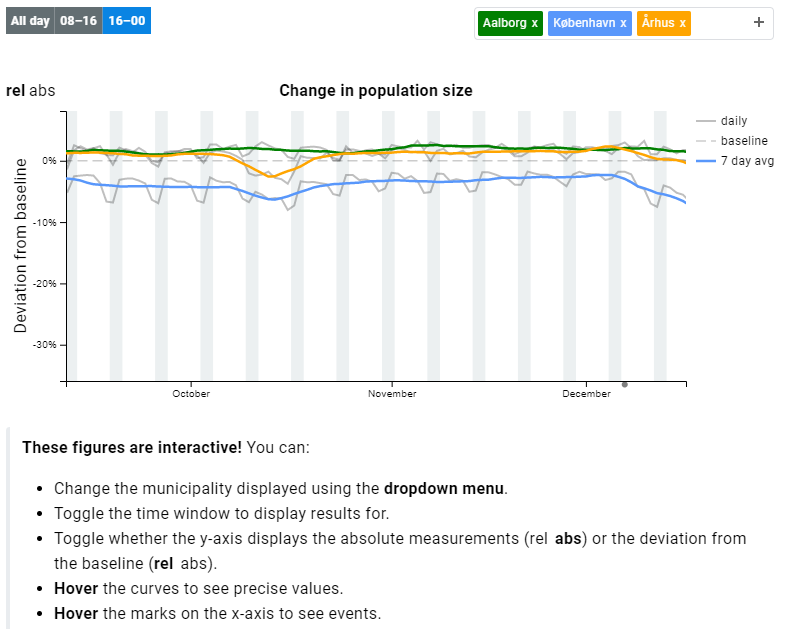

### iii) **Explain in your own words: How is explanatory data analysis different from exploratory data analysis?**


###### **Answer**
Explanatory data analysis is when you know something about the data and you want to communicate that. Exploratory on hte other hand is about exploring and finding something interesting in the data.

# Part 2: Random forest and weather

## **Part 2A: Random forest binary classification.**


Part 2A: Random forest binary classification. 
* Using the and instructions and material from Week 7, build a *random forest* classifier to distinguish between two types (you choose) of crime using on spatio-temporal (where/when) features of data describing the two crimes. When you're done, you should be able to give the classifier a place and a time, and it should tell you which of the two  types of crime happened there.
  - Explain about your choices for training/test data, features, and encoding. (You decide how to present your results, but here are some example topics to consider: Did you balance the training data? What are the pros/cons of balancing? Do you think your model is overfitting? Did you choose to do cross-validation? Which specific features did you end up using? Why? Which features (if any) did you one-hot encode? Why ... or why not?))
  - Report accuracy. Discuss the model performance.

In [5]:
# Filter data
df_p2 = df[(pd.to_datetime(df['Date']) >= '01/01/2003')]
df_p2 = df_p2[(pd.to_datetime(df['Date']) <= '31/12/2017')]

## Creating balanced dataset
df_filtered1 = df_p2[df_p2["Category"]==("VEHICLE THEFT")].sample(40000)
df_filtered2 = df_p2[df_p2["Category"]==("FRAUD")].sample(40000)
df_balanced = pd.concat([df_filtered1,df_filtered2]).sample(frac=1).reset_index()

# One hot Encoding and factorizing the categorical target variable.
X = pd.get_dummies(df_balanced[["PdDistrict","Year","Month","Day","Hour"]])
y = df_balanced["Category"]
y = y.factorize( ['VEHICLE THEFT', 'FRAUD'] )[0]


# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25)

### **Explain about your choices for training/test data, features, and encoding. (You decide how to present your results, but here are some example topics to consider: Did you balance the training data? What are the pros/cons of balancing? Do you think your model is overfitting? Did you choose to do cross-validation? Which specific features did you end up using? Why? Which features (if any) did you one-hot encode? Why ... or why not?))**

**Answer**

To begin with the data is loaded, filtered for dates from 2003-2018 and then "Month of the year" and "Time of the day" columns added according to instructions. The we draw equal amounts of observations from each category in order to maintain balance in the data set Having such a balanced data set ensures that the model is gets euqal amount of each class but it also "deletes" the information that one category is more common than the other. This information could of course greatly improve such a model in cases where the model maybe isn't very . The dataset is also shuffled so that train and test draw later isn't biast.

Before we split into the train and test the categorical varialbe "PdDistrict" is one hot encoded because the model can not understand text so that variable is split into multible and represented as binary one for each district. The target variable which is categorical with only two classes is factorized to be either 0 or 1, again so the model can understand it.

Finally the data set is split into 75% train data and 25% test.

In [6]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 42,min_samples_split = 10)
# Train the model on training data
rf.fit(train_features, train_labels);

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)


### **Training accuracy**

In [7]:
predictions1 = rf.predict(train_features)
print(classification_report(predictions1,train_labels))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85     30265
           1       0.84      0.85      0.84     29735

    accuracy                           0.85     60000
   macro avg       0.85      0.85      0.85     60000
weighted avg       0.85      0.85      0.85     60000



### **Test accuracy**

In [8]:
print(classification_report(predictions,test_labels))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70     10047
           1       0.70      0.70      0.70      9953

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000



### **Report accuracy. Discuss the model performance.**

**Answer**

The model predicts 67% correct which is better than guessing but still not very impressive. The model is definitely overfitting as the training accuracy is 99% which is much higher than the test accuracy.

### **When you're done, you should be able to give the classifier a place and a time, and it should tell you which of the two types of crime happened there.**

In [9]:

#Prediction for one observation
rf.predict(np.array(test_features.iloc[0,:]).reshape(1, -1))

array([0])

If one want to make a prediction for a new observation the above code is an example of this. This will indictate  1 or 0 for either predicting the crime to be a Vehicle Theft or Fraud.

### **Did you choose to do cross-validation?** 

In [10]:

scores = cross_val_score(rf, X, y, cv=5, scoring = "accuracy")
print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))


0.70 accuracy with a standard deviation of 0.005


**Answer** 

Even after trying cross-validation and regularization in the form of restricting the minimum sample split the model does not get better. So to cnclude it is hard to classify the data based on these features. Or that an extensive grid search is needed to make the model better.

## **Part 2B: Info from weather features.**

**Part 2B: Info from weather features.**
* Now add features from weather data to your random forest. 
  - Report accuracy. 
  - Discuss how the model performance changes relative to the version with no weather data.
  - Discuss what you have learned about crime from including weather data in your model.

In [11]:
# REading dat and localizing the time after instructions on slack.

# parse_dates specifies what columns contain dates (instead of a string column -> it becomes a date_time column)
# data_parser -> we specify our custom date_parser (Pandas has default data_parser, usually we do not need to specify it)
# in our data_parser we use "lambda" function - it means that we want to apply something to each value in the column
# pd.to_datetime(x) - converts each value to date_time obect. By default pd.to_datetime assigns GMT0 timezone, 
# which is wrong, thus, we specification of timezone with tz_convert(None)
# now we want to specify the correct timezone -> we use tz_localize("..")
# after we can convert dates to the actual SanFrancisco timezone with tz_convert("..")
# weather.head()


#Loading and adding relevant columns again

df_p2b = df[df["Category"].isin(['VEHICLE THEFT', 'FRAUD'])] # filter out the dataframe, you can plug any list of crimes
df_p2b["datetime"] = df_p2b.apply(lambda x: pd.to_datetime(x.Date + " " + x.Time).round("H").tz_localize("Etc/GMT-7"), axis = 1)  

# Here we do a bit more complicated thing
# .apply allows us to use function for each row of a dataframe (read documentation for more info)
# so we take a row (which is x) and take cell of Date and Time -> and concatenate them to one big string
# that can be then converted to datetime. We would also want to remove any seconds and minutes (round to hours)
# then we specify that dates are in GMT-7
# the result is going to be stored in new "datetime" column


# Left joining in by time stamp in order to get the relevant weather data for each observation.
df_weather = pd.merge(df_p2b,weather,how="left",left_on ="datetime",right_on ="date")
df_weather = df_weather.dropna(subset=["date"])

#Balancing the data after the observatoions with the wather data missing have been dropped.
df_filtered1 = df_weather[df_weather["Category"]==("VEHICLE THEFT")].sample(14301)
df_filtered2 = df_weather[df_weather["Category"]==("FRAUD")].sample(14301)

#Constructing the final df to work with.
df_balanced = pd.concat([df_filtered1,df_filtered2]).sample(frac=1).reset_index()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [12]:

X = pd.get_dummies(df_balanced[['PdDistrict', 'Year',
       'Month', 'Day', 'Hour', 'temperature', 'humidity', 'weather',
       'wind_speed', 'wind_direction', 'pressure']])

y = df_balanced["Category"]
y = y.factorize( ['VEHICLE THEFT', 'FRAUD'] )[0]

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 42)


# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)


### **Train Accuracy**

In [13]:
predictions1 = rf.predict(train_features)
print(classification_report(predictions1,train_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10754
           1       0.99      0.99      0.99     10697

    accuracy                           0.99     21451
   macro avg       0.99      0.99      0.99     21451
weighted avg       0.99      0.99      0.99     21451



### **Test accuracy**

In [14]:
print(classification_report(predictions,test_labels))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68      3767
           1       0.65      0.69      0.67      3384

    accuracy                           0.67      7151
   macro avg       0.67      0.67      0.67      7151
weighted avg       0.68      0.67      0.67      7151



### **Report accuracy and Discuss how the model performance changes relative to the version with no weather data.**

**Answer**

The procedure is exactly like before and the same variables are one hot encoded and factorized. All of the weather data is continuous so no need to manipulate that. 

The model does not perform better even after we added the extra weather data. However as we needed to remove observations that did not have weather data in their corresponding timestamp the second model is trained on 14.000 compared to 40.000.

### **Feature importance / Discuss what you have learned about crime from including weather data in your model.**

In [15]:
print(f'Top 5 feature importance in descending order: \n{X.columns[np.argsort(-rf.feature_importances_)[:5]].values}')

Top 5 feature importance in descending order: 
['Hour' 'temperature' 'wind_direction' 'Day' 'humidity']


The feature importance are very interesting and might give an insight into why the model is not performing better than it is. Basicly the model licks its finger, points it into the air and makes a prediction, like all of us right?

# Part 3: Data visualization

### **Create the Bokeh visualization from Part 2 of the Week 8 Lecture, displayed in a beautiful .gif below.**
###**Provide nice comments for your code. Don't just use the \# inline comments, but the full Notebook markdown capabilities and explain what you're doing.**

The data is filtered based on focus crime and the time period ( $[2010,2018[$ ) :

In [16]:
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])
filter = (df['Year'] >= 2010) & (df['Year'] < 2018) & df.Category.isin(focuscrimes)           # Create filter
df_filtered = df[filter]                                                                      # Apply filter 

The data is grouped by Hour and Category to get the count of each crime type at each given hour. The table is then modified to have the different categoris as columns:

In [17]:
ctdf=(df_filtered.reset_index().groupby(['Hour','Category'], as_index=False).count())
df_24=ctdf.pivot_table(values='index', index='Hour', columns='Category', aggfunc='first')

The hourly count for each category is normalized with respect to the total number counts for the respective crime type. 

In [18]:
df_normal = df_24 / df_24.sum(axis=0)        # normalize data

The Boked figure is initialized:

In [19]:
# hours is added as a colunm in the data frame for for convenience
df_normal['hours'] =[str(i) for i in df_normal.index]
hours = [str(i) for i in df_normal.index]

# Convert the data frame to a ColumnDataSource
source = ColumnDataSource(df_normal)

# Initialize figure
p = figure(x_range = FactorRange(factors=hours), y_range=(0,0.15), plot_width=1300, plot_height = 400)
color = viridis(len(df_24.columns))

The interactive model is generated:

In [20]:
items = []      # list of items (legend, plot)
bar ={}         # list of plots

# generate vbar for each focus crime
for indx,i in enumerate(df_normal.iloc[:,:-1]):
    bar[i] = p.vbar(x ='hours',  top=i, source = source, 
                 muted_alpha=0.5, muted = True,  width = 0.5, color = color[indx])
    items.append((i, [bar[i]]))
 
# position of legends
legend = Legend(items=items, location="center")
p.add_layout(legend, 'left')

# make interactive
p.legend.click_policy="hide"
p.title.text = ("Distribution of focus crimes during a day")
p.title.align = "center"
p.axis
p.yaxis.axis_label = 'Fraction of crime type'
p.xaxis.axis_label = 'Count'
show(p)



As seen from the interactive Bokeh visualization the focus crimes are very similarly distributed during a day. However TRESPASS and DISORDERLY CONDUCT mostly happens during the morning hours and PROSTITUTION and DRIVING UNDER THE INFLUENCE that seems centered around midnight.